In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.layouts import row, column
from bokeh.plotting import show, figure
from bokeh.models import ColumnDataSource, Slider, CustomJS

output_notebook()

Loading BokehJS ...

In [2]:
V_init=-53.
N_init=0.02

params=dict(V_1=[30.0], V_2=[15.0], V_3=[0.0], V_4=[30.0], 
            phi=[0.025], C=[6.698], dt=[1e-4],
            E_L=[-50.0], E_Ca=[100.0], E_K=[-70.0],
            g_L=[0.5], g_Ca=[1.1], g_K=[2.0])

params_source = ColumnDataSource(data=params)

In [3]:
def ml_step(I_syn, V, N, dt, params=params):
    dt = dt*1e3
    V_1 = params['V_1'][0]
    V_2 = params['V_2'][0]
    V_3 = params['V_3'][0]
    V_4 = params['V_4'][0]
    phi = params['phi'][0]
    E_L = params['E_L'][0]
    E_Ca = params['E_Ca'][0]
    E_K = params['E_K'][0]

    g_L = params['g_L'][0]
    g_Ca = params['g_Ca'][0]
    g_K = params['g_K'][0]
    C = params['C'][0]
    
    dV = (I_syn - g_L*(V-E_L) - 0.5*g_Ca*(1+np.tanh((V-V_1)/V_2))*(V-E_Ca) - g_K*N*(V-E_K))/C
    dN = (0.5*(1+np.tanh((V-V_3)/V_4))-N)*(phi*np.cosh((V-V_3)/(2*V_4)))

    V1 = V + dV*dt
    N1 = N + dN*dt
    return [V1, N1]

In [4]:
dt = 1e-4
t = np.arange(0, 1, dt)

I_syn = np.zeros_like(t)
I_syn[2000:3000] = 5

V = np.zeros_like(t)
N = np.zeros_like(t)
V[0] = V_init
N[0] = N_init

In [5]:
for i in range(len(t)):
    V_pre, N_pre = ml_step(I_syn[i], V[i], N[i], dt)
    if i < len(t)-1:
        V[i+1] = V_pre
        
source = ColumnDataSource(data=dict(I=I_syn, V=V, t=t, N=N))

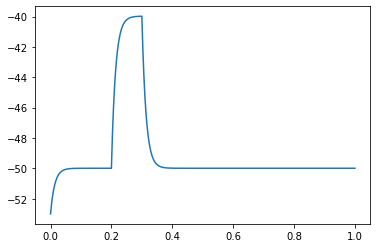

In [6]:
plt.plot(t, V)

In [7]:
callback_V_1 = CustomJS(args=dict(source=source, params_source=params_source), code="""
    const data = source.data;

    const t = data['t']
    const I = data['I']
    const dt = params_source.data['dt'][0]
    const V = Array(t.length).fill(0)
    const N = Array(t.length).fill(0)
    V[0] = data['V'][0]
    N[0] = data['N'][0]
    
    const ml_step = function(I_syn, V, N, params_source, dt){
        dt = dt*1e3
        const V_1 = cb_obj.value
    
        const V_2 = params_source.data['V_2'][0]
        const V_3 = params_source.data['V_3'][0]
        const V_4 = params_source.data['V_4'][0]
        const phi = params_source.data['phi'][0]
        const E_L = params_source.data['E_L'][0]
        const E_Ca = params_source.data['E_Ca'][0]
        const E_K = params_source.data['E_K'][0]

        const g_L = params_source.data['g_L'][0]
        const g_Ca = params_source.data['g_Ca'][0]
        const g_K = params_source.data['g_K'][0]
        const C = params_source.data['C'][0]
        
        const dV = (I_syn - g_L*(V-E_L) - 0.5*g_Ca*(1+Math.tanh((V-V_1)/V_2))*(V-E_Ca) - g_K*N*(V-E_K))/C
        const dN = (0.5*(1+Math.tanh((V-V_3)/V_4))-N)*(phi*Math.cosh((V-V_3)/(2*V_4)))

        const V1 = V + dV*dt
        const N1 = N + dN*dt
        return [V1, N1, V_1]
    }
    let V_1 = 0;
    for (let i=0; i<t.length;i++){
        const pre = ml_step(I[i], V[i], N[i], params_source, dt)
        const V_pre = pre[0]
        const N_pre = pre[1]
        V_1 = pre[2]
        if (i < t.length-1){
            V[i+1] = V_pre
            N[i+1] = N_pre
        }
    }
    
    params_source.data['V_1'][0] = V_1;
    
""")

In [8]:
callback_V_2 = CustomJS(args=dict(source=source, params_source=params_source), code="""
    const data = source.data;

    const t = data['t']
    const I = data['I']
    const dt = params_source.data['dt'][0]
    const V = Array(t.length).fill(0)
    const N = Array(t.length).fill(0)
    V[0] = data['V'][0]
    N[0] = data['N'][0]
    
    const ml_step = function(I_syn, V, N, params_source, dt){
        dt = dt*1e3
        const V_2 = cb_obj.value
    
        const V_1 = params_source.data['V_1'][0]
        const V_3 = params_source.data['V_3'][0]
        const V_4 = params_source.data['V_4'][0]
        const phi = params_source.data['phi'][0]
        const E_L = params_source.data['E_L'][0]
        const E_Ca = params_source.data['E_Ca'][0]
        const E_K = params_source.data['E_K'][0]

        const g_L = params_source.data['g_L'][0]
        const g_Ca = params_source.data['g_Ca'][0]
        const g_K = params_source.data['g_K'][0]
        const C = params_source.data['C'][0]
        
        const dV = (I_syn - g_L*(V-E_L) - 0.5*g_Ca*(1+Math.tanh((V-V_1)/V_2))*(V-E_Ca) - g_K*N*(V-E_K))/C
        const dN = (0.5*(1+Math.tanh((V-V_3)/V_4))-N)*(phi*Math.cosh((V-V_3)/(2*V_4)))

        const V1 = V + dV*dt
        const N1 = N + dN*dt
        return [V1, N1]
    }
    
    let V_2 = 0;
    for (let i=0; i<t.length;i++){
        const pre = ml_step(I[i], V[i], N[i], params_source, dt)
        const V_pre = pre[0]
        const N_pre = pre[1]
        V_2 = pre[2]
        if (i < t.length-1){
            V[i+1] = V_pre
        }
    }
        
    params_source.data['V_2'][0] = V_2;
    
""")

In [9]:
callback_V_3 = CustomJS(args=dict(source=source, params_source=params_source), code="""
    const data = source.data;

    const t = data['t']
    const I = data['I']
    const dt = params_source.data['dt'][0]
    const V = Array(t.length).fill(0)
    const N = Array(t.length).fill(0)
    V[0] = data['V'][0]
    N[0] = data['N'][0]
    
    const ml_step = function(I_syn, V, N, params_source, dt){
        dt = dt*1e3
        const V_3 = cb_obj.value
    
        const V_2 = params_source.data['V_2'][0]
        const V_1 = params_source.data['V_1'][0]
        const V_4 = params_source.data['V_4'][0]
        const phi = params_source.data['phi'][0]
        const E_L = params_source.data['E_L'][0]
        const E_Ca = params_source.data['E_Ca'][0]
        const E_K = params_source.data['E_K'][0]

        const g_L = params_source.data['g_L'][0]
        const g_Ca = params_source.data['g_Ca'][0]
        const g_K = params_source.data['g_K'][0]
        const C = params_source.data['C'][0]
        
        const dV = (I_syn - g_L*(V-E_L) - 0.5*g_Ca*(1+Math.tanh((V-V_1)/V_2))*(V-E_Ca) - g_K*N*(V-E_K))/C
        const dN = (0.5*(1+Math.tanh((V-V_3)/V_4))-N)*(phi*Math.cosh((V-V_3)/(2*V_4)))

        const V1 = V + dV*dt
        const N1 = N + dN*dt
        return [V1, N1, V_3]
    }
    
    let V_3 = 0;
    for (let i=0; i<t.length;i++){
        const pre = ml_step(I[i], V[i], N[i], params_source, dt)
        const V_pre = pre[0]
        const N_pre = pre[1]
        V_3 = pre[2]
        if (i < t.length-1){
            V[i+1] = V_pre
        }
    }
        
    params_source.data['V_2'][0] = V_2;
    
""")

In [10]:
callback_V_4 = CustomJS(args=dict(source=source, params_source=params_source), code="""
    const data = source.data;

    const t = data['t']
    const I = data['I']
    const dt = params_source.data['dt'][0]
    const V = Array(t.length).fill(0)
    const N = Array(t.length).fill(0)
    V[0] = data['V'][0]
    N[0] = data['N'][0]
    
    const ml_step = function(I_syn, V, N, params_source, dt){
        dt = dt*1e3
        const V_4 = cb_obj.value
    
        const V_2 = params_source.data['V_2'][0]
        const V_3 = params_source.data['V_3'][0]
        const V_1 = params_source.data['V_1'][0]
        const phi = params_source.data['phi'][0]
        const E_L = params_source.data['E_L'][0]
        const E_Ca = params_source.data['E_Ca'][0]
        const E_K = params_source.data['E_K'][0]

        const g_L = params_source.data['g_L'][0]
        const g_Ca = params_source.data['g_Ca'][0]
        const g_K = params_source.data['g_K'][0]
        const C = params_source.data['C'][0]
        
        const dV = (I_syn - g_L*(V-E_L) - 0.5*g_Ca*(1+Math.tanh((V-V_1)/V_2))*(V-E_Ca) - g_K*N*(V-E_K))/C
        const dN = (0.5*(1+Math.tanh((V-V_3)/V_4))-N)*(phi*Math.cosh((V-V_3)/(2*V_4)))

        const V1 = V + dV*dt
        const N1 = N + dN*dt
        return [V1, N1, V_4]
    }
    
    let V_4
    for (let i=0; i<t.length;i++){
        const pre = ml_step(I[i], V[i], N[i], params_source, dt)
        const V_pre = pre[0]
        const N_pre = pre[1]
        V_4 = pre[2]
        if (i < t.length-1){
            V[i+1] = V_pre
        }
    }
        
    params_source.data['V_4'][0] = V_4;
    
""")

In [11]:
callback_phi = CustomJS(args=dict(source=source, params_source=params_source), code="""
    const data = source.data;

    const t = data['t']
    const I = data['I']
    const dt = params_source.data['dt'][0]
    const V = Array(t.length).fill(0)
    const N = Array(t.length).fill(0)
    V[0] = data['V'][0]
    N[0] = data['N'][0]
    
    const ml_step = function(I_syn, V, N, params_source, dt){
        dt = dt*1e3
        const phi = cb_obj.value
    
        const V_1 = params_source.data['V_1'][0]
        const V_2 = params_source.data['V_2'][0]
        const V_3 = params_source.data['V_3'][0]
        const V_4 = params_source.data['V_4'][0]
        const E_L = params_source.data['E_L'][0]
        const E_Ca = params_source.data['E_Ca'][0]
        const E_K = params_source.data['E_K'][0]

        const g_L = params_source.data['g_L'][0]
        const g_Ca = params_source.data['g_Ca'][0]
        const g_K = params_source.data['g_K'][0]
        const C = params_source.data['C'][0]
        
        const dV = (I_syn - g_L*(V-E_L) - 0.5*g_Ca*(1+Math.tanh((V-V_1)/V_2))*(V-E_Ca) - g_K*N*(V-E_K))/C
        const dN = (0.5*(1+Math.tanh((V-V_3)/V_4))-N)*(phi*Math.cosh((V-V_3)/(2*V_4)))

        const V1 = V + dV*dt
        const N1 = N + dN*dt
        return [V1, N1, phi]
    }
    
    let phi = 0 
    for (let i=0; i<t.length;i++){
        const pre = ml_step(I[i], V[i], N[i], params_source, dt)
        const V_pre = pre[0]
        const N_pre = pre[1]
        const phi = pre[2]
        if (i < t.length-1){
            V[i+1] = V_pre
        }
    }
    
    params_source.data['phi'][0] = phi;
    
""")

In [12]:
callback_E_L = CustomJS(args=dict(source=source, params_source=params_source), code="""
    const data = source.data;

    const t = data['t']
    const I = data['I']
    const dt = params_source.data['dt'][0]
    const V = Array(t.length).fill(0)
    const N = Array(t.length).fill(0)
    V[0] = data['V'][0]
    N[0] = data['N'][0]
    
    const ml_step = function(I_syn, V, N, params_source, dt){
        dt = dt*1e3
        const E_L = cb_obj.value

        const V_1 = params_source.data['V_1'][0]
        const V_2 = params_source.data['V_2'][0]
        const V_3 = params_source.data['V_3'][0]
        const V_4 = params_source.data['V_4'][0]
        const phi = params_source.data['phi'][0]
        const E_Ca = params_source.data['E_Ca'][0]
        const E_K = params_source.data['E_K'][0]

        const g_L = params_source.data['g_L'][0]
        const g_Ca = params_source.data['g_Ca'][0]
        const g_K = params_source.data['g_K'][0]
        const C = params_source.data['C'][0]
        
        const dV = (I_syn - g_L*(V-E_L) - 0.5*g_Ca*(1+Math.tanh((V-V_1)/V_2))*(V-E_Ca) - g_K*N*(V-E_K))/C
        const dN = (0.5*(1+Math.tanh((V-V_3)/V_4))-N)*(phi*Math.cosh((V-V_3)/(2*V_4)))

        const V1 = V + dV*dt
        const N1 = N + dN*dt
        return [V1, N1, E_L]
    }
    
    let E_L = 0;
    for (let i=0; i<t.length;i++){
        const pre = ml_step(I[i], V[i], N[i], params_source, dt)
        const V_pre = pre[0]
        const N_pre = pre[1]
        E_L = pre[2]
        if (i < t.length-1){
            V[i+1] = V_pre
        }
    }
        
    params_source.data['E_L'][0] = E_L;
    
""")

In [13]:
callback_E_Ca = CustomJS(args=dict(source=source, params_source=params_source), code="""
    const data = source.data;

    const t = data['t']
    const I = data['I']
    const dt = params_source.data['dt'][0]
    const V = Array(t.length).fill(0)
    const N = Array(t.length).fill(0)
    V[0] = data['V'][0]
    N[0] = data['N'][0]
    
    const ml_step = function(I_syn, V, N, params_source, dt){
        dt = dt*1e3
        const E_Ca = cb_obj.value

        const V_1 = params_source.data['V_1'][0]
        const V_2 = params_source.data['V_2'][0]
        const V_3 = params_source.data['V_3'][0]
        const V_4 = params_source.data['V_4'][0]
        const phi = params_source.data['phi'][0]
        const E_L = params_source.data['E_L'][0]
        const E_K = params_source.data['E_K'][0]

        const g_L = params_source.data['g_L'][0]
        const g_Ca = params_source.data['g_Ca'][0]
        const g_K = params_source.data['g_K'][0]
        const C = params_source.data['C'][0]
        
        const dV = (I_syn - g_L*(V-E_L) - 0.5*g_Ca*(1+Math.tanh((V-V_1)/V_2))*(V-E_Ca) - g_K*N*(V-E_K))/C
        const dN = (0.5*(1+Math.tanh((V-V_3)/V_4))-N)*(phi*Math.cosh((V-V_3)/(2*V_4)))

        const V1 = V + dV*dt
        const N1 = N + dN*dt
        return [V1, N1, E_Ca]
    }
    
    let E_Ca = 0;
    for (let i=0; i<t.length;i++){
        const pre = ml_step(I[i], V[i], N[i], params_source, dt)
        const V_pre = pre[0]
        const N_pre = pre[1]
        E_Ca = pre[2]
        if (i < t.length-1){
            V[i+1] = V_pre
        }
    }
        
    params_source.data['E_Ca'][0] = E_Ca;
    
""")

In [14]:
callback_E_K = CustomJS(args=dict(source=source, params_source=params_source), code="""
    const data = source.data;

    const t = data['t']
    const I = data['I']
    const dt = params_source.data['dt'][0]
    const V = Array(t.length).fill(0)
    const N = Array(t.length).fill(0)
    V[0] = data['V'][0]
    N[0] = data['N'][0]
    
    const ml_step = function(I_syn, V, N, params_source, dt){
        dt = dt*1e3
        const E_K = cb_obj.value

        const V_1 = params_source.data['V_1'][0]
        const V_2 = params_source.data['V_2'][0]
        const V_3 = params_source.data['V_3'][0]
        const V_4 = params_source.data['V_4'][0]
        const phi = params_source.data['phi'][0]
        const E_Ca = params_source.data['E_Ca'][0]
        const E_L = params_source.data['E_L'][0]

        const g_L = params_source.data['g_L'][0]
        const g_Ca = params_source.data['g_Ca'][0]
        const g_K = params_source.data['g_K'][0]
        const C = params_source.data['C'][0]
        
        const dV = (I_syn - g_L*(V-E_L) - 0.5*g_Ca*(1+Math.tanh((V-V_1)/V_2))*(V-E_Ca) - g_K*N*(V-E_K))/C
        const dN = (0.5*(1+Math.tanh((V-V_3)/V_4))-N)*(phi*Math.cosh((V-V_3)/(2*V_4)))

        const V1 = V + dV*dt
        const N1 = N + dN*dt
        return [V1, N1, E_K]
    }
    
    let E_K = 0;
    for (let i=0; i<t.length;i++){
        const pre = ml_step(I[i], V[i], N[i], params_source, dt)
        const V_pre = pre[0]
        const N_pre = pre[1]
        E_K = pre[2]
        if (i < t.length-1){
            V[i+1] = V_pre
        }
    }
        
    params_source.data['E_K'][0] = E_K;
    
""")

In [15]:
callback_g_L = CustomJS(args=dict(source=source, params_source=params_source), code="""
    const data = source.data;

    const t = data['t']
    const I = data['I']
    const dt = params_source.data['dt'][0]
    const V = Array(t.length).fill(0)
    const N = Array(t.length).fill(0)
    V[0] = data['V'][0]
    N[0] = data['N'][0]
    
    const ml_step = function(I_syn, V, N, params_source, dt){
        dt = dt*1e3
        const g_L = cb_obj.value

        const V_1 = params_source.data['V_1'][0]
        const V_2 = params_source.data['V_2'][0]
        const V_3 = params_source.data['V_3'][0]
        const V_4 = params_source.data['V_4'][0]
        const phi = params_source.data['phi'][0]
        const E_L = params_source.data['E_L'][0]
        const E_Ca = params_source.data['E_Ca'][0]
        const E_K = params_source.data['E_K'][0]

        const g_Ca = params_source.data['g_Ca'][0]
        const g_K = params_source.data['g_K'][0]
        const C = params_source.data['C'][0]
        
        const dV = (I_syn - g_L*(V-E_L) - 0.5*g_Ca*(1+Math.tanh((V-V_1)/V_2))*(V-E_Ca) - g_K*N*(V-E_K))/C
        const dN = (0.5*(1+Math.tanh((V-V_3)/V_4))-N)*(phi*Math.cosh((V-V_3)/(2*V_4)))

        const V1 = V + dV*dt
        const N1 = N + dN*dt
        return [V1, N1, g_L]
    }
    
    let g_L = 0;
    for (let i=0; i<t.length;i++){
        const pre = ml_step(I[i], V[i], N[i], params_source, dt)
        const V_pre = pre[0]
        const N_pre = pre[1]
        g_L = pre[2]
        if (i < t.length-1){
            V[i+1] = V_pre
        }
    }
        
    params_source.data['g_L'][0] = g_L;
    
""")

In [16]:
callback_g_Ca = CustomJS(args=dict(source=source, params_source=params_source), code="""
    const data = source.data;

    const t = data['t']
    const I = data['I']
    const dt = params_source.data['dt'][0]
    const V = Array(t.length).fill(0)
    const N = Array(t.length).fill(0)
    V[0] = data['V'][0]
    N[0] = data['N'][0]
    
    const ml_step = function(I_syn, V, N, params_source, dt){
        dt = dt*1e3
        const g_Ca = cb_obj.value

        const V_1 = params_source.data['V_1'][0]
        const V_2 = params_source.data['V_2'][0]
        const V_3 = params_source.data['V_3'][0]
        const V_4 = params_source.data['V_4'][0]
        const phi = params_source.data['phi'][0]
        const E_L = params_source.data['E_L'][0]
        const E_Ca = params_source.data['E_Ca'][0]
        const E_K = params_source.data['E_K'][0]

        const g_L = params_source.data['g_L'][0]
        const g_K = params_source.data['g_K'][0]
        const C = params_source.data['C'][0]
        
        const dV = (I_syn - g_L*(V-E_L) - 0.5*g_Ca*(1+Math.tanh((V-V_1)/V_2))*(V-E_Ca) - g_K*N*(V-E_K))/C
        const dN = (0.5*(1+Math.tanh((V-V_3)/V_4))-N)*(phi*Math.cosh((V-V_3)/(2*V_4)))

        const V1 = V + dV*dt
        const N1 = N + dN*dt
        return [V1, N1, g_Ca]
    }
    
    let g_Ca = 0
    for (let i=0; i<t.length;i++){
        const pre = ml_step(I[i], V[i], N[i], params_source, dt)
        const V_pre = pre[0]
        const N_pre = pre[1]
        g_Ca = pre[2]
        if (i < t.length-1){
            V[i+1] = V_pre
        }
    }
        
    params_source.data['g_Ca'][0] = g_Ca;
    
""")

In [17]:
callback_g_K = CustomJS(args=dict(source=source, params_source=params_source), code="""
    const data = source.data;

    const t = data['t']
    const I = data['I']
    const dt = params_source.data['dt'][0]
    const V = Array(t.length).fill(0)
    const N = Array(t.length).fill(0)
    V[0] = data['V'][0]
    N[0] = data['N'][0]
    
    const ml_step = function(I_syn, V, N, params_source, dt){
        dt = dt*1e3
        const g_K = cb_obj.value

        const V_1 = params_source.data['V_1'][0]
        const V_2 = params_source.data['V_2'][0]
        const V_3 = params_source.data['V_3'][0]
        const V_4 = params_source.data['V_4'][0]
        const phi = params_source.data['phi'][0]
        const E_L = params_source.data['E_L'][0]
        const E_Ca = params_source.data['E_Ca'][0]
        const E_K = params_source.data['E_K'][0]

        const g_Ca = params_source.data['g_Ca'][0]
        const g_L = params_source.data['g_L'][0]
        const C = params_source.data['C'][0]
        
        const dV = (I_syn - g_L*(V-E_L) - 0.5*g_Ca*(1+Math.tanh((V-V_1)/V_2))*(V-E_Ca) - g_K*N*(V-E_K))/C
        const dN = (0.5*(1+Math.tanh((V-V_3)/V_4))-N)*(phi*Math.cosh((V-V_3)/(2*V_4)))

        const V1 = V + dV*dt
        const N1 = N + dN*dt
        return [V1, N1, g_K]
    }
    
    let g_K = 0;
    for (let i=0; i<t.length;i++){
        const pre = ml_step(I[i], V[i], N[i], params_source, dt)
        const V_pre = pre[0]
        const N_pre = pre[1]
        g_K = pre[2]
        if (i < t.length-1){
            V[i+1] = V_pre
        }
    }
        
    params_source.data['g_K'][0] = g_K;
    
""")

In [18]:
callback_C = CustomJS(args=dict(source=source, params_source=params_source), code="""
    const data = source.data;

    const t = data['t']
    const I = data['I']
    const dt = params_source.data['dt'][0]
    const V = Array(t.length).fill(0)
    const N = Array(t.length).fill(0)
    V[0] = data['V'][0]
    N[0] = data['N'][0]
    
    const ml_step = function(I_syn, V, N, params_source, dt){
        dt = dt*1e3
        const C = cb_obj.value

        const V_1 = params_source.data['V_1'][0]
        const V_2 = params_source.data['V_2'][0]
        const V_3 = params_source.data['V_3'][0]
        const V_4 = params_source.data['V_4'][0]
        const phi = params_source.data['phi'][0]
        const E_L = params_source.data['E_L'][0]
        const E_Ca = params_source.data['E_Ca'][0]
        const E_K = params_source.data['E_K'][0]

        const g_L = params_source.data['g_L'][0]
        const g_Ca = params_source.data['g_Ca'][0]
        const g_K = params_source.data['g_K'][0]
        
        const dV = (I_syn - g_L*(V-E_L) - 0.5*g_Ca*(1+Math.tanh((V-V_1)/V_2))*(V-E_Ca) - g_K*N*(V-E_K))/C
        const dN = (0.5*(1+Math.tanh((V-V_3)/V_4))-N)*(phi*Math.cosh((V-V_3)/(2*V_4)))

        const V1 = V + dV*dt
        const N1 = N + dN*dt
        return [V1, N1, C]
    }
    
    let C = 0;
    for (let i=0; i<t.length;i++){
        const pre = ml_step(I[i], V[i], N[i], params_source, dt)
        const V_pre = pre[0]
        const N_pre = pre[1]
        C = pre[2]
        if (i < t.length-1){
            V[i+1] = V_pre
        }
    }
        
    params_source.data['C'][0] = C;
    
""")

In [19]:
plot = figure(width=600, height=400)
# plot.line('t', 'I', source=source, line_color='orange', legend_label='I_syn')
plot.line('t', 'V', source=source, line_color='skyblue', legend_label='V')

# plot.legend.click_policy='hide'


slider_V_1 = Slider(start=-120.0, end=120.0, value=30.0, step=.5, title="V_1")
slider_V_2 = Slider(start=-120.0, end=120.0, value=15.0, step=.5, title="V_2")
slider_V_3 = Slider(start=-120.0, end=120.0, value=0.0, step=.5, title="V_3")
slider_V_4 = Slider(start=-120.0, end=120.0, value=30.0, step=.5, title="V_4")
slider_V_init = Slider(start=-120.0, end=120.0, value=-50.0, step=.5, title="V_init")
slider_N_init = Slider(start=-5.0, end=5.0, value=0.02, step=.01, title="N_init")
slider_E_L = Slider(start=-120.0, end=120.0, value=-50.0, step=.5, title="E_L")
slider_E_K = Slider(start=-120.0, end=120.0, value=-70.0, step=.5, title="E_K")
slider_E_Ca = Slider(start=-120.0, end=120.0, value=100.0, step=.5, title="E_Ca")
slider_g_L = Slider(start=-10.0, end=10.0, value=0.5, step=.1, title="g_L")
slider_g_K = Slider(start=-10.0, end=10.0, value=2.0, step=.1, title="g_K")
slider_g_Ca = Slider(start=-10.0, end=10.0, value=1.1, step=.1, title="g_Ca")
slider_phi = Slider(start=0, end=5, value=0.025, step=.025, title="phi")
slider_C = Slider(start=0.0, end=10.0, value=6.0, step=.1, title="C")

slider_V_1.js_on_change('value_throttled', callback_V_1)
slider_V_2.js_on_change('value_throttled', callback_V_2)
slider_V_3.js_on_change('value_throttled', callback_V_3)
slider_V_4.js_on_change('value_throttled', callback_V_4)
slider_E_L.js_on_change('value_throttled', callback_E_L)
slider_E_K.js_on_change('value_throttled', callback_E_K)
slider_E_Ca.js_on_change('value_throttled', callback_E_Ca)
slider_g_L.js_on_change('value_throttled', callback_g_L)
slider_g_K.js_on_change('value_throttled', callback_g_K)
slider_g_Ca.js_on_change('value_throttled', callback_g_Ca)
slider_phi.js_on_change('value_throttled', callback_phi)
slider_C.js_on_change('value_throttled', callback_C)

inputs = column(slider_V_1, slider_V_2, slider_V_3, slider_V_4,
                slider_E_L, slider_E_K, slider_E_Ca,
                slider_g_L, slider_g_K, slider_g_Ca,
                slider_phi, slider_C)

layout = row(inputs, plot)

show(layout)